In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


class LadderNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LadderNet, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Decoder layers
        self.deconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.deconv1 = nn.ConvTranspose2d(32, 1, kernel_size=4, padding=1)

        # Classification layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x_labeled, x_unlabeled):
        if (x_labeled is not None):

            # Labeled input
            h = F.relu(self.bn1(self.conv1(x_labeled)))
            h = F.max_pool2d(h, 2, 2)
            out1 = h
            h = F.relu(self.bn2(self.conv2(h)))
            h = F.max_pool2d(h, 2, 2)
            out2 = h
            h = F.relu(self.bn3(self.conv3(h)))
            h = F.max_pool2d(h, 2, 2)
            out3 = h
            encoder_output = F.relu(self.bn4(self.conv4(h)))

        else:

            # Unlabeled input
            u = F.relu(self.bn1(self.conv1(x_unlabeled)))
            u = F.max_pool2d(u, 2, 2)
            out1 = u
            u = F.relu(self.bn2(self.conv2(u)))
            u = F.max_pool2d(u, 2, 2)
            out2 = u
            u = F.relu(self.bn3(self.conv3(u)))
            u = F.max_pool2d(u, 2, 2)
            out3 = u
            encoder_output = F.relu(self.bn4(self.conv4(u)))

        encoder_output = F.avg_pool2d(encoder_output, encoder_output.size()[2:])
        decoder_input = encoder_output
        encoder_output = encoder_output.view(-1, 256)

        # Add noise to the hidden representations
        noise = torch.randn_like(encoder_output)
        distorted_encoder_output = encoder_output + noise

        # Decoder
        u = F.relu(self.bn5(self.deconv4(distorted_encoder_output.view(-1, 256, 1, 1))))
        u = F.interpolate(u, scale_factor=3, mode='nearest')
        dout3 = u
        u = F.relu(self.bn6(self.deconv3(u)))
        u = F.interpolate(u, size=(7, 7), mode='nearest')
        dout2 = u
        u = F.relu(self.bn7(self.deconv2(u)))
        u = F.interpolate(u, size=(14, 14), mode='nearest')
        dout1 = u
        u = F.interpolate(self.deconv1(u), size=(28, 28), mode='nearest')
        x_reconstructed = torch.sigmoid(u)

        # Classification
        output = self.fc(encoder_output) if x_labeled is not None else None

        return output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3

    def labeled_loss(self, output_labeled, target_labeled):
        criterion = nn.CrossEntropyLoss()
        return criterion(output_labeled, target_labeled)

    def reconstruction_loss(self, x_reconstructed, x_unlabeled, out1, dout1, out2, dout2, out3, dout3):
        mse_loss = nn.MSELoss()
        mse = mse_loss(x_reconstructed, x_unlabeled) + 0.25 * (
                mse_loss(out1, dout1) + mse_loss(out2, dout2) + mse_loss(out3, dout3))

        return mse

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
# Divide the training set into labeled and unlabeled sets
n_labeled = int(0.1 * len(train_set))
n_unlabeled = len(train_set) - n_labeled
train_labeled_set, train_unlabeled_set = torch.utils.data.random_split(train_set, [n_labeled, n_unlabeled])

# Create data loaders for the labeled and unlabeled sets
batch_size = 128

from torch.utils.data import Dataset


class SemisupervisedDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.unlabeled_size = len(unlabeled_dataset)
        self.labeled_size = len(labeled_dataset)
        print("Dataset created")

    def __len__(self):
        return self.unlabeled_size

    def __getitem__(self, index):
        labeled_data, labeled_target = self.labeled_dataset[index % self.labeled_size]
        unlabeled_data, _ = self.unlabeled_dataset[index]

        return labeled_data, labeled_target, unlabeled_data


dataset = SemisupervisedDataset(train_labeled_set, train_unlabeled_set)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

simple_labeled_dataloader = torch.utils.data.DataLoader(train_labeled_set, batch_size=batch_size, shuffle=True, pin_memory=True)
simple_labeled_test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Dataset created


In [4]:
from sklearn.metrics import classification_report


def plot_history(loss, accuracy, loss_dictionary, accuracy_dictionary, name):
    # create the accuracy plot
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
    plt.plot(accuracy)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # create the loss plot
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
    plt.plot(loss)
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # display the plots
    plt.tight_layout()  # to prevent overlapping of labels
    plt.show()

    loss_dictionary[name] = loss.copy()
    accuracy_dictionary[name] = accuracy.copy()


def evaluate_model(model, test_loader):
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            preds.extend(output.argmax(dim=1, keepdim=True).flatten().numpy())
            targets.extend(target.numpy())
    print(classification_report(targets, preds))

In [5]:
from tqdm import tqdm
from torch import optim

# Define the model
model = LadderNet(input_shape=(1, 28, 28), num_classes=10)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss
reconstruction_loss_fn = model.reconstruction_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []
accuracy_plots = {}
loss_plots = {}

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled, data_unlabeled in tqdm(dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)
        data_unlabeled = data_unlabeled.to(device)

        optimizer.zero_grad()
        output, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(data_labeled, None)
        loss_labeled = labeled_loss_fn(output, target_labeled) + reconstruction_loss_fn(data_labeled, x_reconstructed,
                                                                                        out1, dout1, out2, dout2, out3,
                                                                                        dout3)
        loss_labeled.backward()
        optimizer.step()

        # Train the model on the unlabeled data
        _, x_reconstructed, out1, dout1, out2, dout2, out3, dout3 = model(None, data_unlabeled)
        x_reconstructed = x_reconstructed.view(-1, 784)
        data_unlabeled = data_unlabeled.view(-1, 784)
        loss_unlabeled = reconstruction_loss_fn(data_unlabeled, x_reconstructed, out1, dout1, out2, dout2, out3, dout3)
        loss_unlabeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _, _, _, _, _, _, _ = model(data, None)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 422/422 [03:16<00:00,  2.15it/s]


Epoch: 0 Test set: Average loss: 0.0035, Accuracy: 8485/10000 (85%)


100%|██████████| 422/422 [03:15<00:00,  2.16it/s]


Epoch: 1 Test set: Average loss: 0.0040, Accuracy: 8632/10000 (86%)


100%|██████████| 422/422 [03:26<00:00,  2.05it/s]


Epoch: 2 Test set: Average loss: 0.0049, Accuracy: 8604/10000 (86%)


100%|██████████| 422/422 [03:26<00:00,  2.04it/s]


Epoch: 3 Test set: Average loss: 0.0048, Accuracy: 8701/10000 (87%)


100%|██████████| 422/422 [03:15<00:00,  2.16it/s]


Epoch: 4 Test set: Average loss: 0.0051, Accuracy: 8793/10000 (88%)


100%|██████████| 422/422 [03:26<00:00,  2.04it/s]


Epoch: 5 Test set: Average loss: 0.0050, Accuracy: 8824/10000 (88%)


100%|██████████| 422/422 [03:16<00:00,  2.15it/s]


Epoch: 6 Test set: Average loss: 0.0054, Accuracy: 8582/10000 (86%)


100%|██████████| 422/422 [03:14<00:00,  2.17it/s]


Epoch: 7 Test set: Average loss: 0.0050, Accuracy: 8834/10000 (88%)


100%|██████████| 422/422 [03:14<00:00,  2.17it/s]


Epoch: 8 Test set: Average loss: 0.0053, Accuracy: 8793/10000 (88%)


100%|██████████| 422/422 [03:14<00:00,  2.17it/s]


Epoch: 9 Test set: Average loss: 0.0056, Accuracy: 8711/10000 (87%)


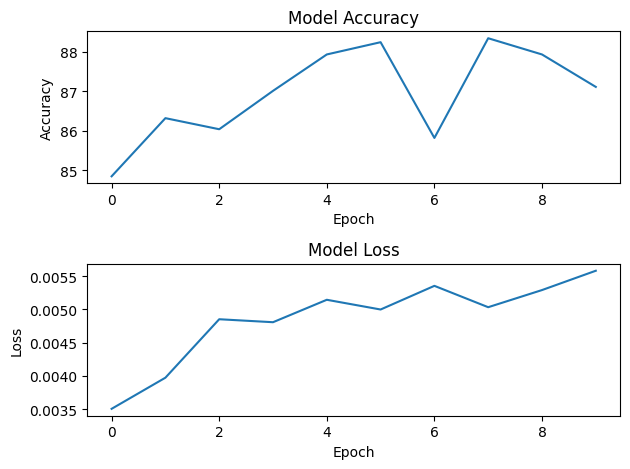

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.98      0.97      0.98      1000
           2       0.83      0.77      0.80      1000
           3       0.86      0.91      0.88      1000
           4       0.78      0.79      0.78      1000
           5       0.94      0.98      0.96      1000
           6       0.65      0.62      0.63      1000
           7       0.94      0.96      0.95      1000
           8       0.96      0.96      0.96      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [6]:
plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'ladder with 0.25 reconstruction cost')
evaluate_model(model, test_loader)

## Звичайна модель

In [7]:
class SimpleModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SimpleModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Classification layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x_labeled):
        # Labeled input
        h = F.relu(self.bn1(self.conv1(x_labeled)))
        h = F.max_pool2d(h, 2, 2)
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pool2d(h, 2, 2)
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.max_pool2d(h, 2, 2)
        encoder_output = F.relu(self.bn4(self.conv4(h)))
        encoder_output = F.avg_pool2d(encoder_output, encoder_output.size()[2:])
        encoder_output = encoder_output.view(-1, 256)

        # Classification

        output = self.fc(encoder_output)

        return output


    def labeled_loss(self, output_labeled, target_labeled):
        criterion = nn.CrossEntropyLoss()
        return criterion(output_labeled, target_labeled)

In [8]:
from tqdm import tqdm
from torch import optim

# Define the model
model = SimpleModel(input_shape=(1, 28, 28), num_classes=10)

# Move the model to the device
model.to(device)

# Define the loss functions
labeled_loss_fn = model.labeled_loss

num_epochs = 10

# Define the optimizer
optimizer = optim.Adam(model.parameters())

accuracy_plot = []
loss_plot = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for data_labeled, target_labeled in tqdm(simple_labeled_dataloader):
        # Train the model on the labeled data
        data_labeled = data_labeled.to(device)
        target_labeled = target_labeled.to(device)

        optimizer.zero_grad()
        output = model(data_labeled)
        loss_labeled = labeled_loss_fn(output, target_labeled)
        loss_labeled.backward()
        optimizer.step()

    # Test the model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in simple_labeled_test_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += labeled_loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(simple_labeled_test_dataloader.dataset)
    accuracy = 100. * correct / len(simple_labeled_test_dataloader.dataset)
    loss_plot.append(test_loss)
    accuracy_plot.append(accuracy)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, test_loss, correct,
                                                                                       len(test_loader.dataset),
                                                                                       accuracy))

100%|██████████| 47/47 [00:08<00:00,  5.42it/s]


Epoch: 0 Test set: Average loss: 0.0047, Accuracy: 7931/10000 (79%)


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch: 1 Test set: Average loss: 0.0043, Accuracy: 8160/10000 (82%)


100%|██████████| 47/47 [00:08<00:00,  5.39it/s]


Epoch: 2 Test set: Average loss: 0.0038, Accuracy: 8281/10000 (83%)


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


Epoch: 3 Test set: Average loss: 0.0042, Accuracy: 8171/10000 (82%)


100%|██████████| 47/47 [00:08<00:00,  5.24it/s]


Epoch: 4 Test set: Average loss: 0.0040, Accuracy: 8135/10000 (81%)


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


Epoch: 5 Test set: Average loss: 0.0083, Accuracy: 7210/10000 (72%)


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


Epoch: 6 Test set: Average loss: 0.0035, Accuracy: 8546/10000 (85%)


100%|██████████| 47/47 [00:08<00:00,  5.34it/s]


Epoch: 7 Test set: Average loss: 0.0074, Accuracy: 7461/10000 (75%)


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


Epoch: 8 Test set: Average loss: 0.0050, Accuracy: 8170/10000 (82%)


100%|██████████| 47/47 [00:08<00:00,  5.27it/s]


Epoch: 9 Test set: Average loss: 0.0040, Accuracy: 8510/10000 (85%)


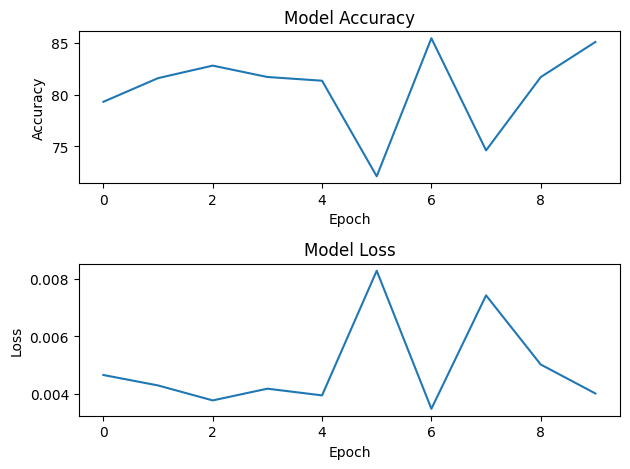

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1000
           1       0.98      0.97      0.97      1000
           2       0.88      0.68      0.77      1000
           3       0.94      0.78      0.85      1000
           4       0.59      0.95      0.73      1000
           5       0.98      0.93      0.95      1000
           6       0.75      0.51      0.61      1000
           7       0.95      0.91      0.93      1000
           8       0.99      0.94      0.96      1000
           9       0.89      0.98      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000



In [9]:
def evaluate_simple_model(model, test_loader):
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            preds.extend(output.argmax(dim=1, keepdim=True).flatten().numpy())
            targets.extend(target.numpy())
    print(classification_report(targets, preds))

plot_history(loss_plot, accuracy_plot, loss_plots, accuracy_plots, 'simple model learned only on supervised part of dataset')
evaluate_simple_model(model, test_loader)

In [10]:
def plot_accuracy_history(dictionary):
    plt.figure()
    for label, history in dictionary.items():
        plt.plot(history, label=label)

    plt.legend()
    plt.title('Accuracy History for Models')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # display the plot
    plt.show()

def plot_loss_history(dictionary):
    plt.figure()
    for label, history in dictionary.items():
        plt.plot(history, label=label)

    plt.legend()
    plt.title('Loss History for Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # display the plot
    plt.show()

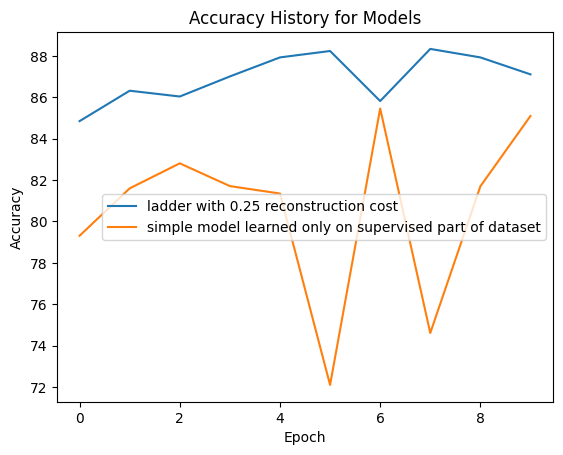

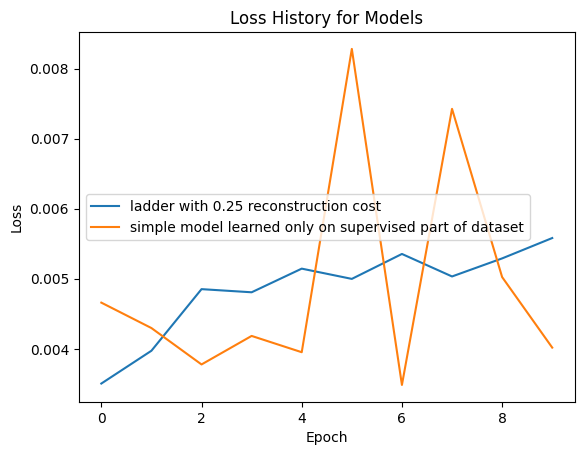

In [11]:
plot_accuracy_history(accuracy_plots)
plot_loss_history(loss_plots)